# Google Colab

# Mount google drive files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Packages

In [2]:
from tensorflow.keras.layers import Dense, LSTM, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

In [3]:
print(f'Tensorflow {tf.__version__}')

Tensorflow 2.14.0


# Load dataset

In [4]:
# train dataset
train_file = r'/content/drive/MyDrive/AI/Slove_Captcha_DhHue/index.txt'
read_txt = open(train_file, encoding="utf8")

data = [s.strip() for s in read_txt.readlines()]

images = []
labels = []

for d in data:
  x, y = d.split(':')
  if len(y) != 4:
    continue
  images.append(cv2.imread(f'/content/drive/MyDrive/AI/Slove_Captcha_DhHue/{x}'))
  labels.append(y)

# conver to numpy array
images = np.array(images)
labels = np.array(labels)

# split train test
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

In [5]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2690, 30, 150, 3)
(2690,)
(299, 30, 150, 3)
(299,)


- ## Show some patch

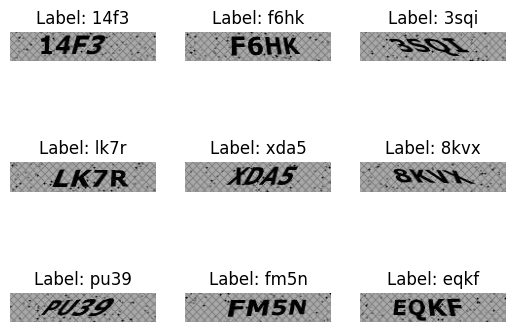

In [6]:
def show_random_images(x, y):
    random_indices = np.random.choice(len(x), 9, replace=False)

    for i, idx in enumerate(random_indices):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[idx], cmap='gray')
        plt.title(f"Label: {y[idx]}")
        plt.axis('off')
    plt.show()

show_random_images(x_train, y_train)

In [7]:
char_ = list(set(char for label in labels for char in label))
char_list = sorted(char_)
print(char_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [8]:
# encode label
def encode_to_labels(text, char_map):
  labels = []

  for char in text:
    labels.append(char_map.index(char))

  return labels

# decode one hotvector
def decode_from_labels(vector, char_map):
    text = ""
    for v in vector:
        char = char_map[int(v)]
        text += char
    return text

In [9]:
print("Encode:", encode_to_labels('g519', char_list))
print("Decode:", decode_from_labels([16, 5, 1, 9], char_list))

Encode: [16, 5, 1, 9]
Decode: g519


# Image - Pre-processing

In [10]:
def pre_processing(image):
  # cover image to gray scale
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  # Blur it use GaussianBlur
  blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)

  # edges detect
  edges = cv2.Canny(blurred_image, 230, 270)

  # nomarllize image
  nomarllize_image = edges/255.

  # crop image
  top, bottom, left, right = 3, 3, 30, 30
  cropped_image = nomarllize_image[top:nomarllize_image.shape[0]-bottom, left:nomarllize_image.shape[1]-right]

  # add chanel dimenstion
  process_image = np.expand_dims(cropped_image, axis=-1)

  return process_image

In [11]:
# processing images
x_train = np.array([pre_processing(image) for image in x_train])
# x_test = np.array([pre_processing(image) for image in x_test])
print(x_train.shape)
# print(x_test.shape)

(2690, 24, 90, 1)


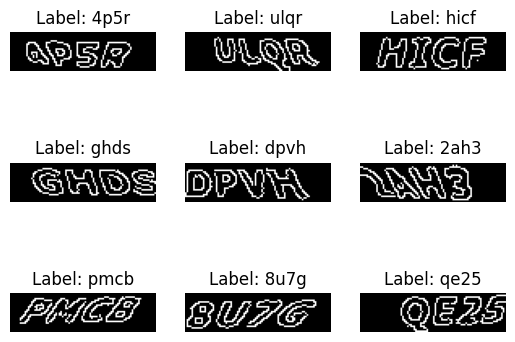

In [12]:
show_random_images(x_train, y_train)

In [13]:
# encode labels
y_train = np.array([encode_to_labels(y, char_list) for y in y_train])
# y_test = np.array([encode_to_labels(y, char_list) for y in y_test])
print(y_train.shape)
# print(y_test.shape)

(2690, 4)
(299, 4)


# Convolutional Recurrent Neural Network (CRNN) Architecture

In [14]:
def create_crnn_model():
  inputs = Input(shape=(24, 90, 1))

  # Convolutional layers
  conv_1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
  pool_1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_1)

  conv_2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool_1)
  pool_2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(conv_2)

  conv_3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool_2)

  conv_4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv_3)
  batch_norm_4 = BatchNormalization()(conv_4)
  pool_4 = MaxPool2D(pool_size=(2, 1))(batch_norm_4)

  conv_5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool_4)
  batch_norm_5 = BatchNormalization()(conv_5)
  pool_5 = MaxPool2D(pool_size=(2, 1))(batch_norm_5)

  conv_6 = Conv2D(512, (3, 3), activation='relu', padding='valid')(batch_norm_5)
  # batch_norm_6 = BatchNormalization()(conv_6)


  # conv_7 = Conv2D(512, (2, 2), activation='relu', padding='valid')(pool_6)

  squeezed = Lambda(lambda x: K.squeeze(x, 1))(conv_6)

  # Bidirectional LSTM layers
  blstm_1 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(squeezed)
  blstm_2 = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(blstm_1)

  # Output layer
  outputs = Dense(len(char_list) + 1, activation='softmax') (blstm_2)

  # Model for testing
  act_model = Model(inputs, outputs)

  return act_model

In [15]:
crnn_model = create_crnn_model()
crnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 90, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 24, 90, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 45, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 45, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 22, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 22, 256)        295168

## CTC loss

In [16]:
labels = Input(name='the_labels', shape=[4], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([crnn_model.output, labels, input_length, label_length])

# model to be used at training time
crnn_model = Model(inputs=[crnn_model.input, labels, input_length, label_length], outputs=loss_out)

In [17]:
crnn_model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="/content/drive/MyDrive/AI/Slove_Captcha_DhHue/best_model.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

In [19]:
batch_size = 128
epochs = 50
train_input_length = np.full(len(x_train), 20)
train_label_length = np.full(len(y_train), 4)
crnn_model.fit(x=[x_train, y_train, train_input_length, train_label_length], y=np.zeros(len(x_train)), batch_size=batch_size, epochs = epochs, validation_split=0.2, verbose = 1, callbacks = callbacks_list)


Epoch 1/50
17/17 [==============================] - ETA: 0s - loss: 19.3934
Epoch 1: val_loss improved from inf to 15.80812, saving model to /content/drive/MyDrive/AI/Slove_Captcha_DhHue/best_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 25s 441ms/step - loss: 19.3934 - val_loss: 15.8081
Epoch 2/50
17/17 [==============================] - ETA: 0s - loss: 15.4145
Epoch 2: val_loss improved from 15.80812 to 15.49971, saving model to /content/drive/MyDrive/AI/Slove_Captcha_DhHue/best_model.hdf5
17/17 [==============================] - 3s 164ms/step - loss: 15.4145 - val_loss: 15.4997
Epoch 3/50
17/17 [==============================] - ETA: 0s - loss: 15.3081
Epoch 3: val_loss improved from 15.49971 to 15.45852, saving model to /content/drive/MyDrive/AI/Slove_Captcha_DhHue/best_model.hdf5
17/17 [==============================] - 2s 134ms/step - loss: 15.3081 - val_loss: 15.4585
Epoch 4/50
17/17 [==============================] - ETA: 0s - loss: 15.1893
Epoch 4: val_loss did not improve from 15.45852
17/17 [==============================] - 2s 118ms/step - loss: 15.1893 - val_loss: 15.4791
Epoch 5/50
17/17 [==============================] - ETA: 0s - loss: 14.9828
Epoch 5: val_loss i

# Predict

In [22]:
# load the saved best model weights
predict_model = create_crnn_model()
predict_model.load_weights('/content/drive/MyDrive/AI/Slove_Captcha_DhHue/best_model.hdf5')

# processing test data
test_data = np.array([pre_processing(image) for image in x_test])
print(test_data.shape)

# predict outputs on validation images
## predict one image
# image = x_test[0]
# prediction = predict_model.predict(np.expand_dims(image, axis=0))

## predict on test data
prediction = predict_model.predict(test_data)

# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                         greedy=True)[0][0])

# see the results
y_pred = []
for x in out:
  text = []
  for p in x:
    if int(p) != -1:
      text.append(p)
  y_pred.append(decode_from_labels(text, char_list))

(299, 24, 90, 1)
10/10 [==============================] - 2s 14ms/step


## Show result

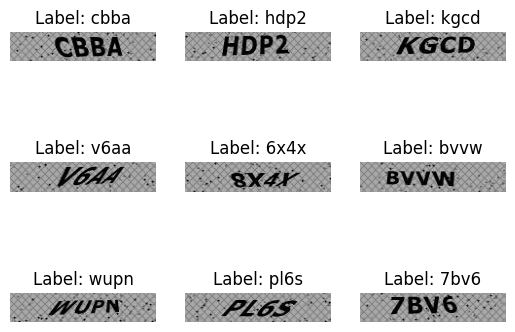

In [23]:
show_random_images(x_test, np.array(y_pred))